
Bad key text.latex.unicode in file /Users/fukai/.matplotlib/stylelib/paper-default2.mplstyle, line 46 ('text.latex.unicode: True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution
Duplicate key in file PosixPath('/Users/fukai/.matplotlib/stylelib/paper-default.mplstyle'), line 38 ('legend.framealpha: 1.0')
the value of the environment variable BASIC_DCT_BACKEND is not in ["JAX","OPENCV","SCIPY"]


(147, 128, 128) uint16


findfont: Font family ['IPAPGothic'] not found. Falling back to DejaVu Sans.


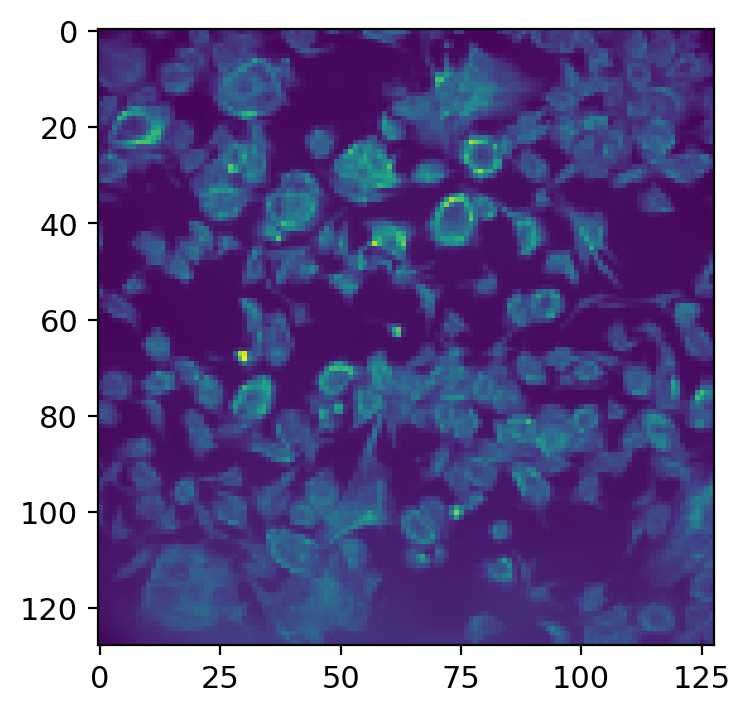

(100, 128, 171) uint8


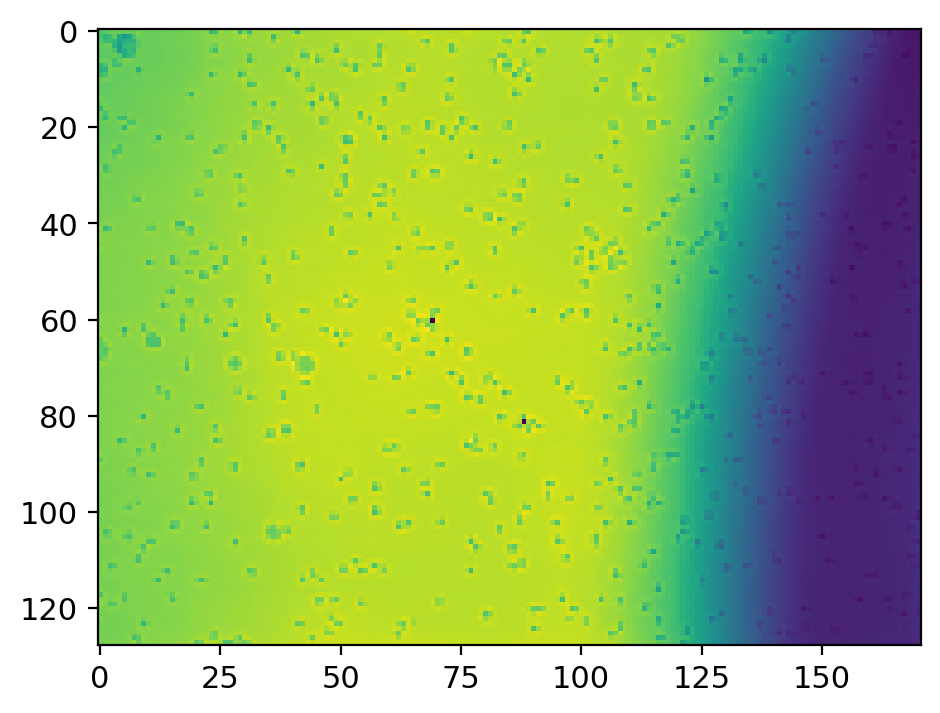

(189, 128, 171) uint8


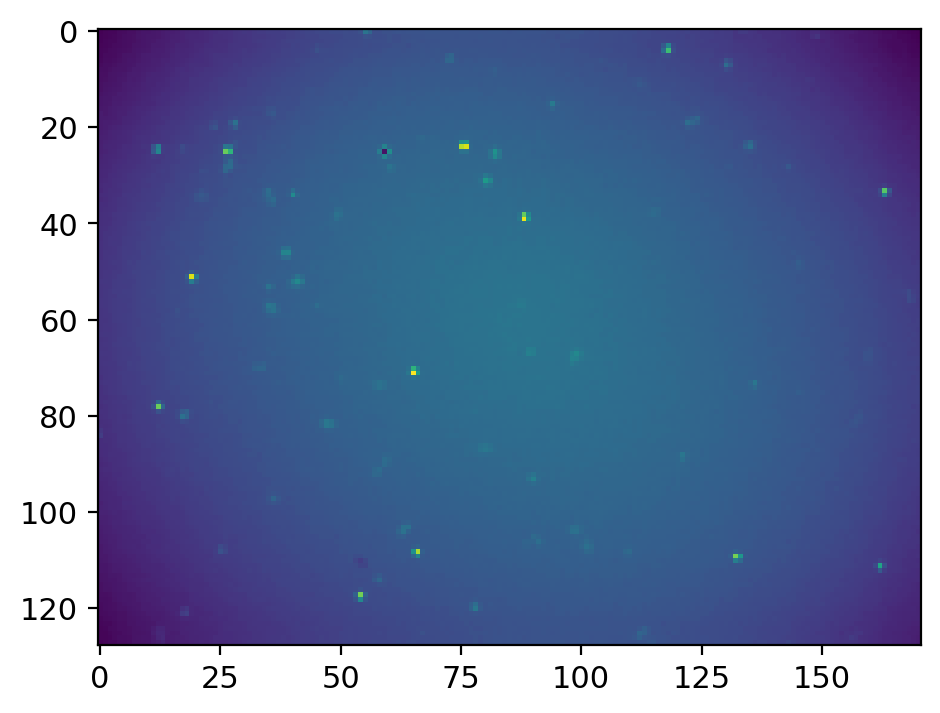

(200, 128, 171) uint8


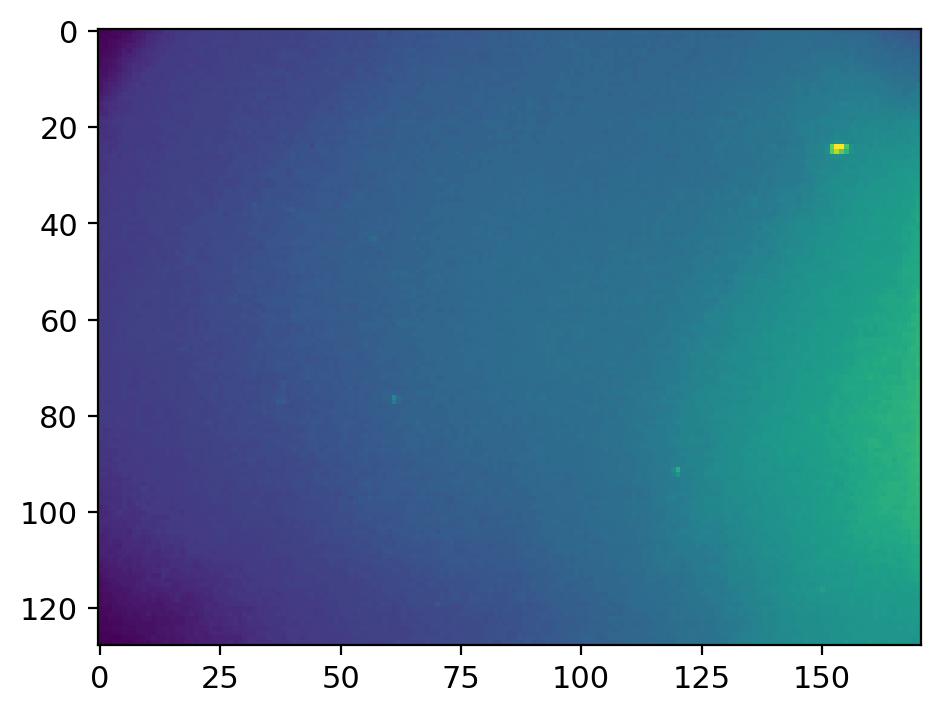

(63, 128, 128) uint16


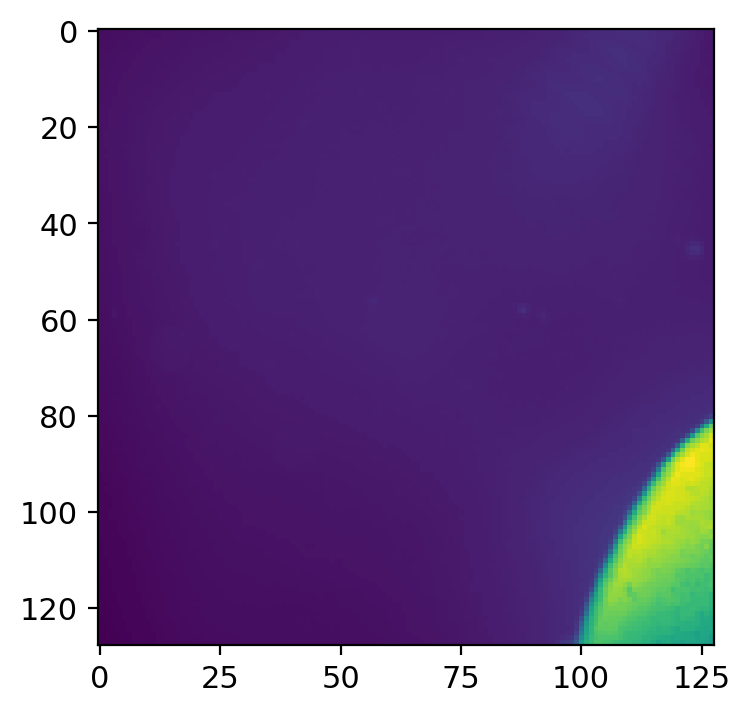

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from basicpy import BaSiC

images = {}
keys = ["cell_culture","timelapse_brightfield","timelapse_nanog","timelapse_pu1","wsi_brain"]
for k in keys:
    d=np.load(f"../data/{k}.npz")
    im=d["images"]
    print(im.shape, im.dtype)
    plt.imshow(im[10])
    images[k]=im
    plt.show()

# Comparing with previous implemnetation

In [2]:
from skimage.transform import resize as skresize
RESIZE_ORDER = 1
RESIZE_MODE = "symmetric"
_preserve_range = True
def _resize_images_list(images_list, side_size: float = None, x_side_size: float = None, y_side_size: float = None):
    if side_size is not None:
        y_side_size = x_side_size = side_size
    resized_images_list = []
    for i, im in enumerate(images_list):
        if im.shape[0] != x_side_size or im.shape[1] != y_side_size:
            resized_images_list.append(skresize(
                im, 
                (x_side_size, y_side_size), 
                order = RESIZE_ORDER, 
                mode = RESIZE_MODE,
                preserve_range = _preserve_range
                )
            )
        else:
            resized_images_list.append(im)
    return np.array(resized_images_list)

def _resize_image(image: np.ndarray, side_size: float  = None, x_side_size: float = None, y_side_size: float = None):
    if side_size is not None:
        y_side_size = x_side_size = side_size
    if image.shape[0] != x_side_size or image.shape[1] != y_side_size:
        return skresize(
            image,
            (x_side_size, y_side_size), 
            order = RESIZE_ORDER, 
            mode = RESIZE_MODE,
            preserve_range = _preserve_range
        )
    else:
        return image


I_B  2921.7292
I_R  -10.003871
I_R  0.8459635
R1  2910.8801
B  2900.8767
residual  -10.849841
Y  0.0
Y  -3.5166377e-05
mu  3.241185595470597e-06
mu  4.8617785e-06
I_B  2910.88
I_R  -6.3873177
I_R  1.8671291
R1  2909.859
B  2899.8552
residual  -1.021032
Y  -3.5166377e-05
Y  -4.0130817e-05
mu  4.8617785e-06
mu  7.2926678e-06
I_B  2909.8586
I_R  -3.6356978
I_R  3.509752
R1  2908.2166
B  2898.213
residual  -1.642522
Y  -4.0130817e-05
Y  -5.2110678e-05
mu  7.2926678e-06
mu  1.0939002e-05
I_B  2908.2158
I_R  -1.2537959
I_R  8.73956
R1  2902.987
B  2892.9832
residual  -5.229724
Y  -5.2110678e-05
Y  -0.00010931868
mu  1.0939002e-05
mu  1.6408503e-05
I_B  2902.9863
I_R  2.077042
I_R  14.28594
R1  2897.4404
B  2887.4368
residual  -5.54633
Y  -0.00010931868
Y  -0.00020032561
mu  1.6408503e-05
mu  2.4612755e-05
I_B  2897.4407
I_R  6.146849
I_R  18.83691
R1  2892.8892
B  2882.8855
residual  -4.5509305
Y  -0.00020032561
Y  -0.00031233593
mu  2.4612755e-05
mu  3.6919133e-05
I_B  2892.8896
I_R  10.376

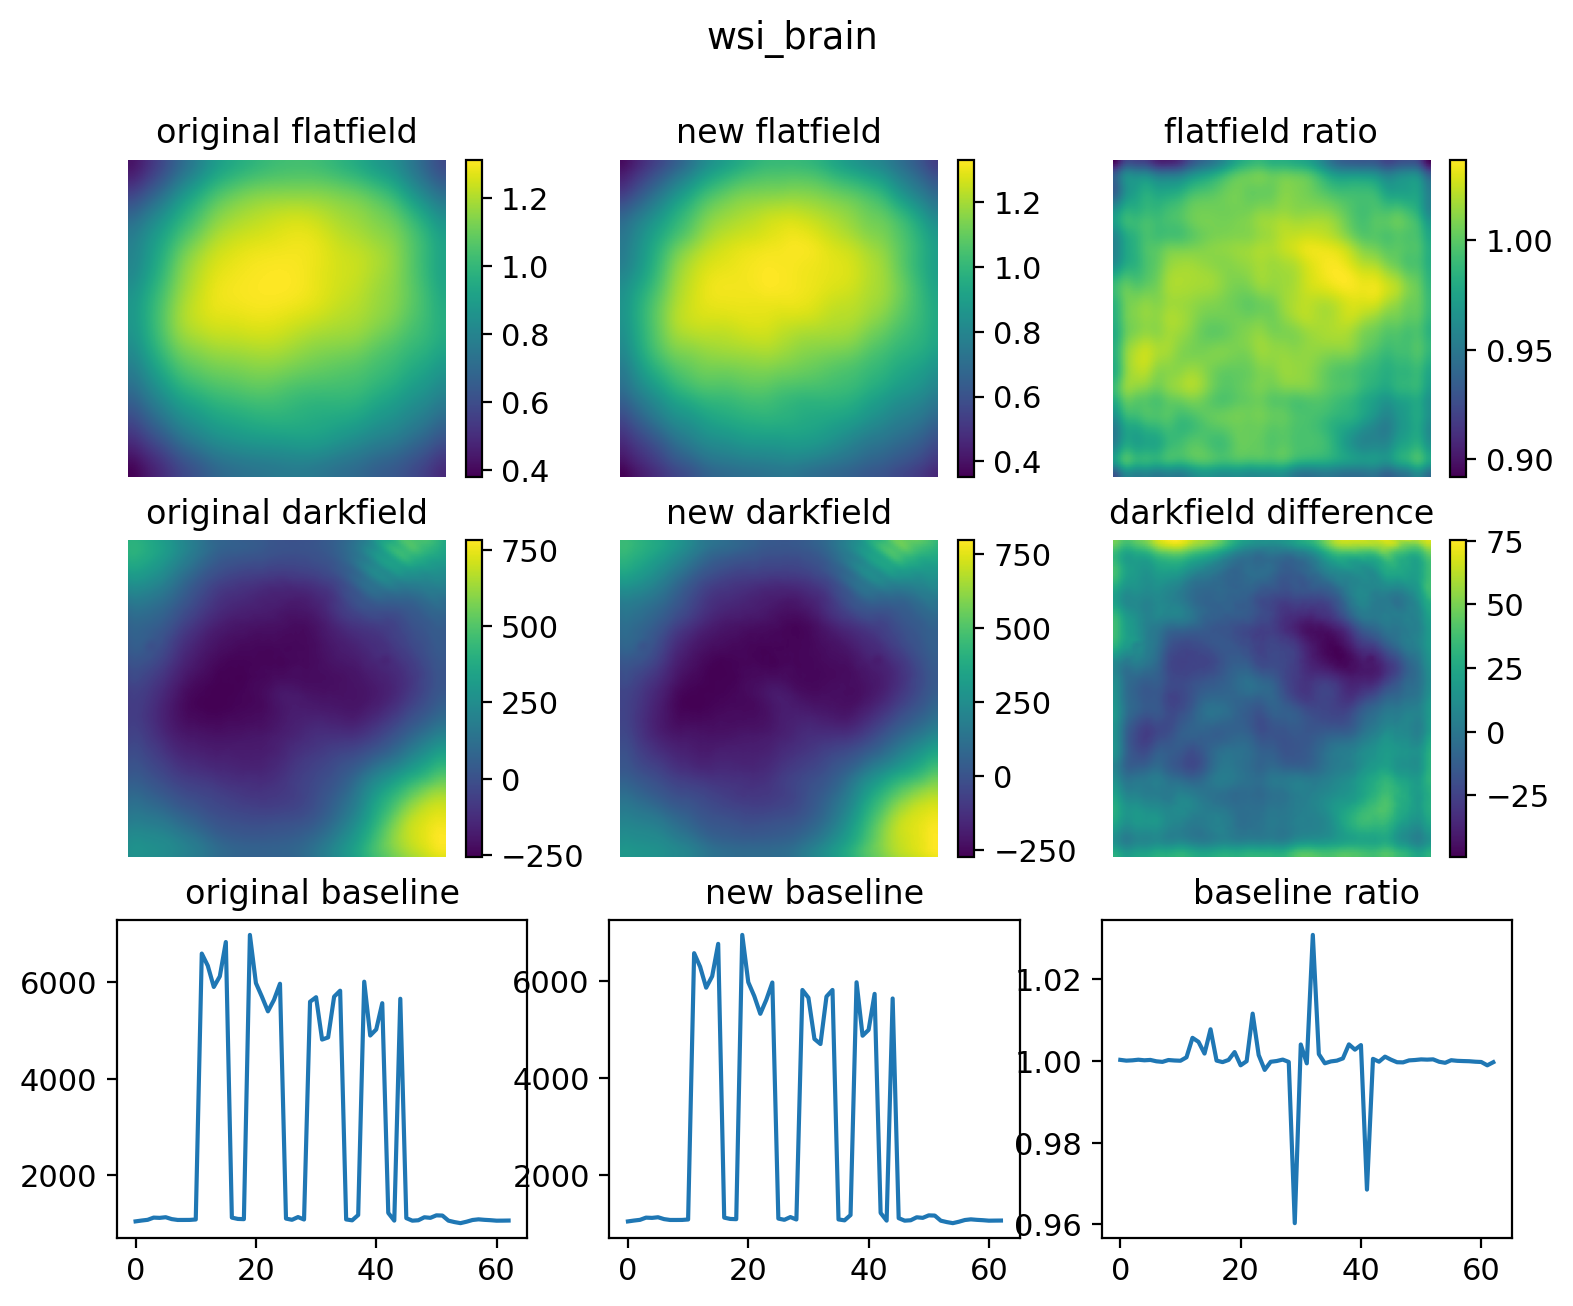

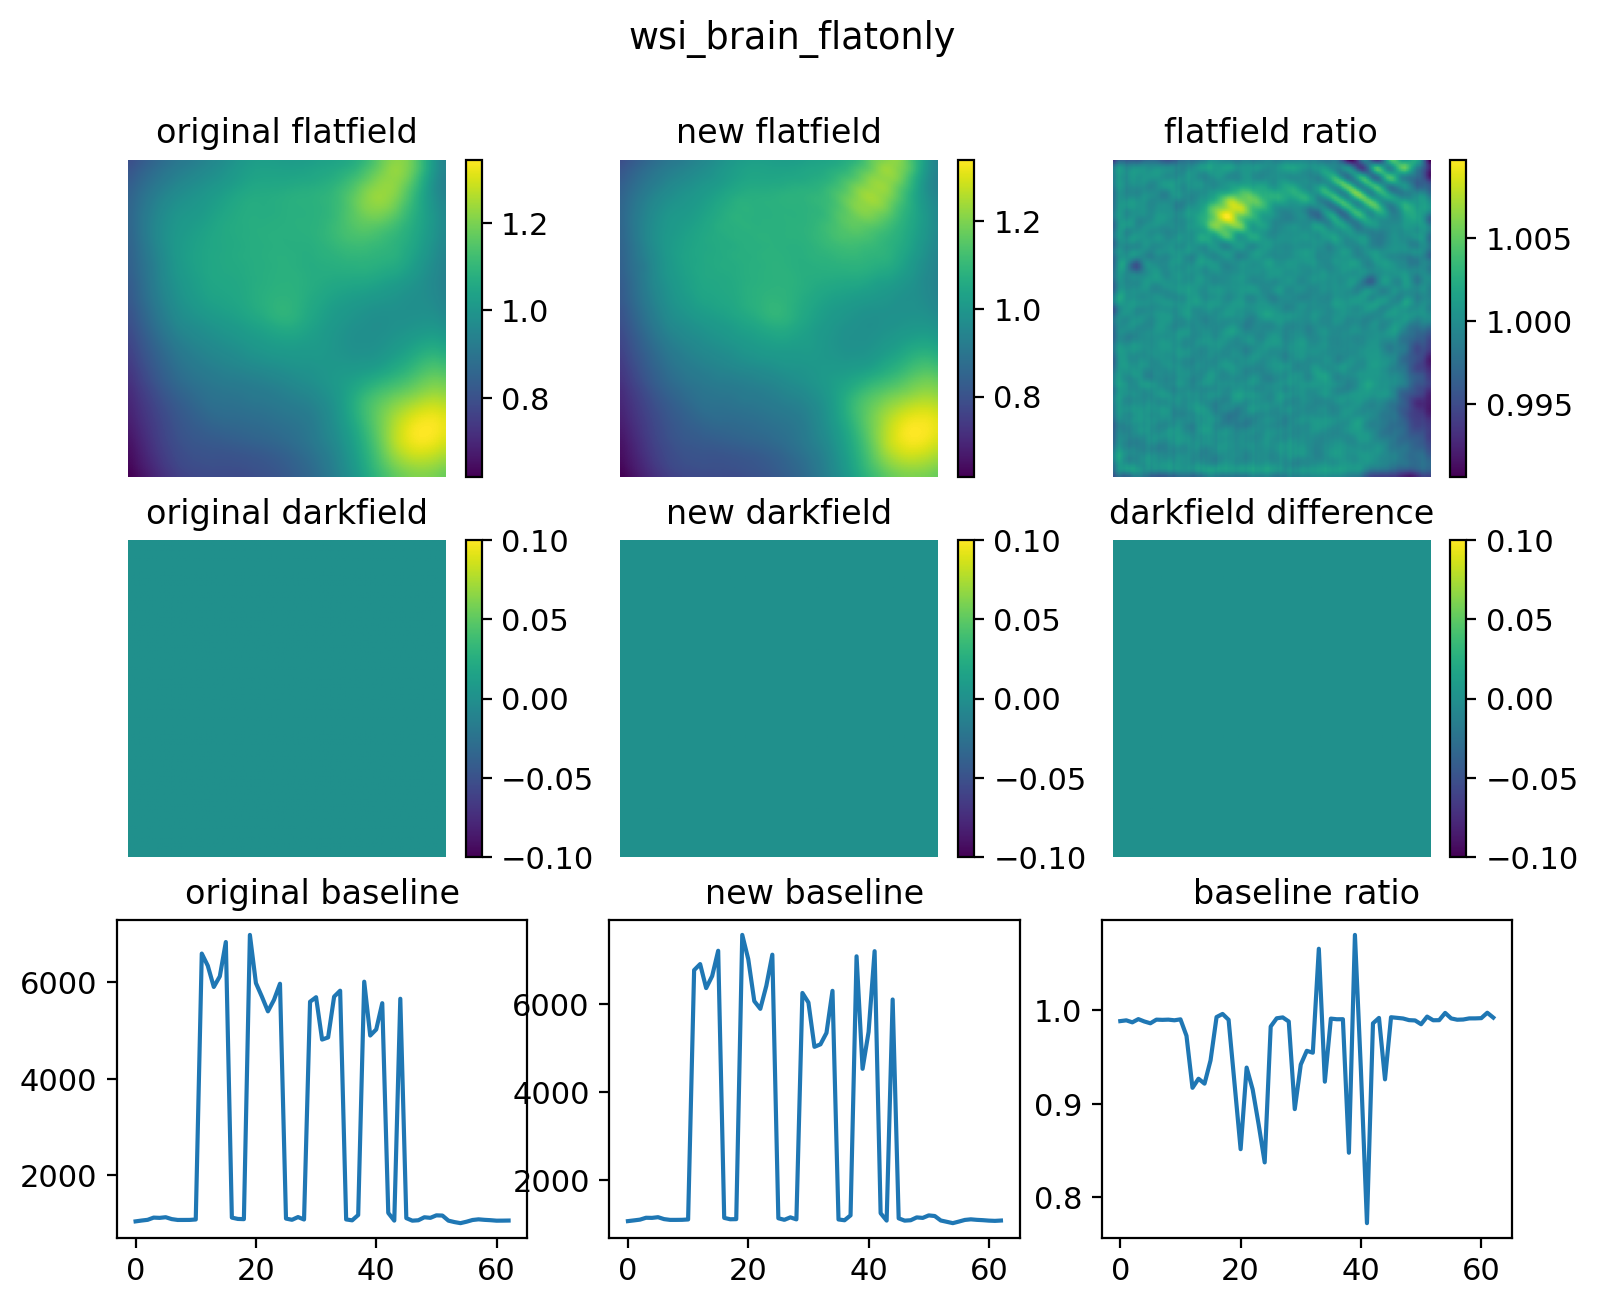

In [4]:
from itertools import product
import os
import logging
logging.getLogger("basicpy").setLevel(level=logging.WARNING)

os.makedirs("../tests/data/fit", exist_ok=True)

for k,im in list(images.items())[-1:]:
    d=np.load(f"../data/{k}.npz")
    im=d["images"]
    im2=im.copy()
    im2=_resize_images_list(im2,128)
    for get_darkfield in [True, False]:
        suffix="_flatonly" if not get_darkfield else ""
        flatfield_original = d["flatfield"+suffix]
        darkfield_original = d["darkfield"+suffix]
        baseline_original = d["baseline"+suffix]
        b = BaSiC(fitting_mode="approximate",
                    working_size=None,
                    get_darkfield=get_darkfield, 
                    
                    sort_intensity=True)
        b.fit(im2)
        flatfield_new=_resize_image(b.flatfield,x_side_size=im.shape[1],y_side_size=im.shape[2])
        darkfield_new=_resize_image(b.darkfield,x_side_size=im.shape[1],y_side_size=im.shape[2])
        plotted_data=[
        flatfield_original,
        flatfield_new,
        flatfield_new/flatfield_original,
        darkfield_original,
        darkfield_new,
        darkfield_new-darkfield_original
        ]
        titles=[
        "original flatfield",
        "new flatfield",
        "flatfield ratio",
        "original darkfield",
        "new darkfield",
        "darkfield difference",
        ]

        fig, axes = plt.subplots(3, 3, figsize=(9,7))
        fig.suptitle(f"{k}{suffix}")
        for ax,data,t in zip(np.ravel(axes),plotted_data,titles):
            _im = ax.imshow(data)
            fig.colorbar(_im, ax=ax)
            ax.set_title(t)
            ax.axis("off")
        
        axes[2,0].plot(baseline_original)
        axes[2,1].plot(b.baseline)
        axes[2,2].plot(baseline_original/b.baseline)
        axes[2,0].set_title("original baseline")
        axes[2,1].set_title("new baseline")
        axes[2,2].set_title("baseline ratio")

In [34]:
d=np.load(f"../data/{k}.npz")
im=d["images"]
im2=im.copy()
im2=_resize_images_list(im2,128)

get_darkfield=False
suffix="_flatonly" if not get_darkfield else ""
flatfield_original = d["flatfield"+suffix]
darkfield_original = d["darkfield"+suffix]
baseline_original = d["baseline"+suffix]
b = BaSiC(fitting_mode="approximate",
            working_size=None,
            #max_iterations=1,
            #max_reweight_iterations=1,
            #max_reweight_iterations_baseline=1,
            get_darkfield=get_darkfield,
            sort_intensity=True)
b.fit(im2)
flatfield_new=_resize_image(b.flatfield,x_side_size=im.shape[1],y_side_size=im.shape[2])
darkfield_new=_resize_image(b.darkfield,x_side_size=im.shape[1],y_side_size=im.shape[2])

I_B  2911.7268
I_R  -5.4253476e-05
I_R  0.7253875
R1  2911.0007
B  2911.0012
residual  -0.7254387
Y  0.0
Y  -2.351198e-06
mu  3.241185595470597e-06
mu  4.8617785e-06
I_B  2911.001
I_R  0.24150935
I_R  1.794847
R1  2909.9314
B  2909.9316
residual  -1.0695103
Y  -2.351198e-06
Y  -7.5504545e-06
mu  4.8617785e-06
mu  7.2926678e-06
I_B  2909.9312
I_R  0.7589751
I_R  2.9871144
R1  2908.739
B  2908.7393
residual  -1.1923093
Y  -7.5504545e-06
Y  -1.62454e-05
mu  7.2926678e-06
mu  1.0939002e-05
I_B  2908.7397
I_R  1.502364
I_R  7.7972674
R1  2903.9287
B  2903.9292
residual  -4.810202
Y  -1.62454e-05
Y  -6.88578e-05
mu  1.0939002e-05
mu  1.6408503e-05
I_B  2903.9292
I_R  3.6003537
I_R  13.588802
R1  2898.1377
B  2898.1375
residual  -5.7915816
Y  -6.88578e-05
Y  -0.00016389528
mu  1.6408503e-05
mu  2.4612755e-05
I_B  2898.1377
I_R  6.9298816
I_R  13.935383
R1  2897.7905
B  2897.791
residual  -0.34681535
Y  -0.00016389528
Y  -0.0001724282
mu  2.4612755e-05
mu  3.6919133e-05
I_B  2897.7913
I_R  9.2

In [58]:
from jax import numpy as jnp
newax = jnp.newaxis
def _shrinkage(x, thresh):
    return np.sign(x) * np.maximum(np.abs(x) - thresh, 0)
def _jshrinkage(x, thresh):
    return jnp.sign(x) * jnp.maximum(jnp.abs(x) - thresh, 0)
def _step_only_baseline(self, Im, weight, S, D, vals,max_mu):
    _ent1=1.
    k, I_R, B, Y, mu, fit_residual = vals
    I_B = S[newax, ...] * B[:, newax, newax] + D[newax, ...]
    print("I_B ",I_B.mean())

    # update I_R using approximated l0 norm
    I_R = I_R + (Im - I_B - I_R + (1 / mu) * Y) / _ent1
    print("I_R ",I_R.mean())
    I_R = _jshrinkage(I_R, weight / (_ent1 * mu))
    print("I_R ",I_R.mean())

    R1 = Im - I_R
    print("R1 ",R1.mean())
    # A1_coeff = mean(R1)-mean(A_offset);
    B = jnp.mean(R1, axis=(1, 2)) - jnp.mean(D)
    print("B ",B.mean())
    # A1_coeff(A1_coeff<0) = 0;
    B = jnp.maximum(B, 0)
    # Z1 = D - A1_hat - E1_hat;
    fit_residual = Im - I_B - I_R
    print("residual ",fit_residual.mean())
    # Y1 = Y1 + mu*Z1;
    print("Y ",Y.mean())
    Y = Y + mu * fit_residual
    print("Y ",Y.mean())
    print("mu ",mu)
    mu = jnp.minimum(mu * self.rho, max_mu)
    print("mu ",mu)
    return (k + 1, I_R, B, Y, mu, fit_residual)

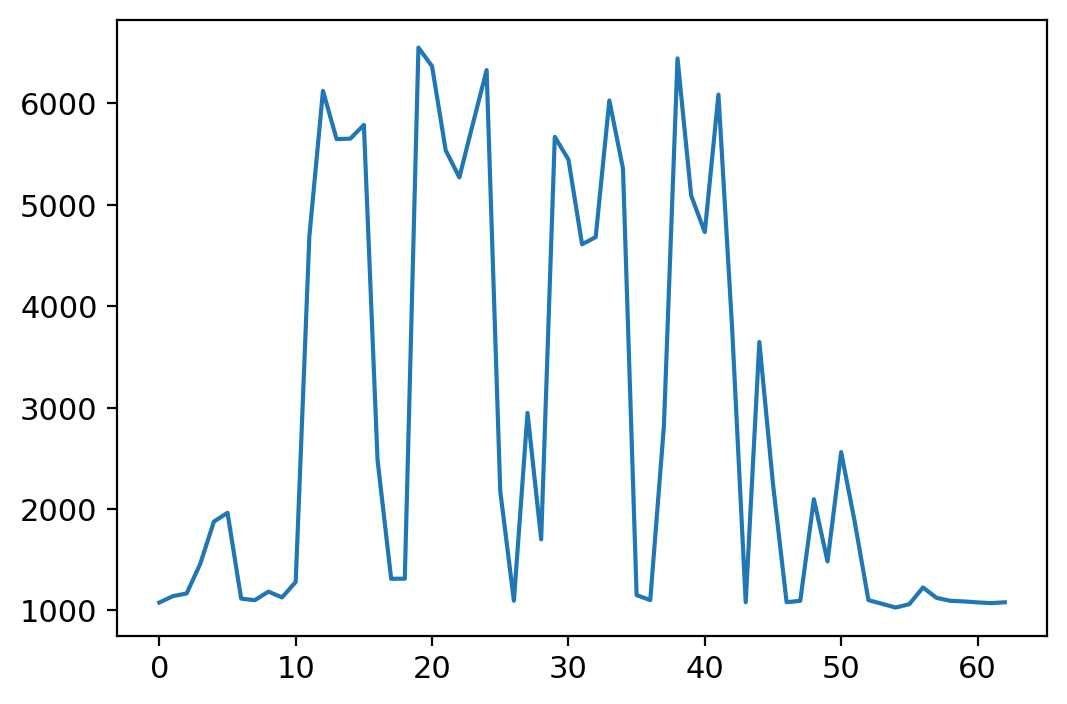

In [33]:
plt.plot(B)

I_B  2911.726178653194
I_R  3.1036898552028358e-06


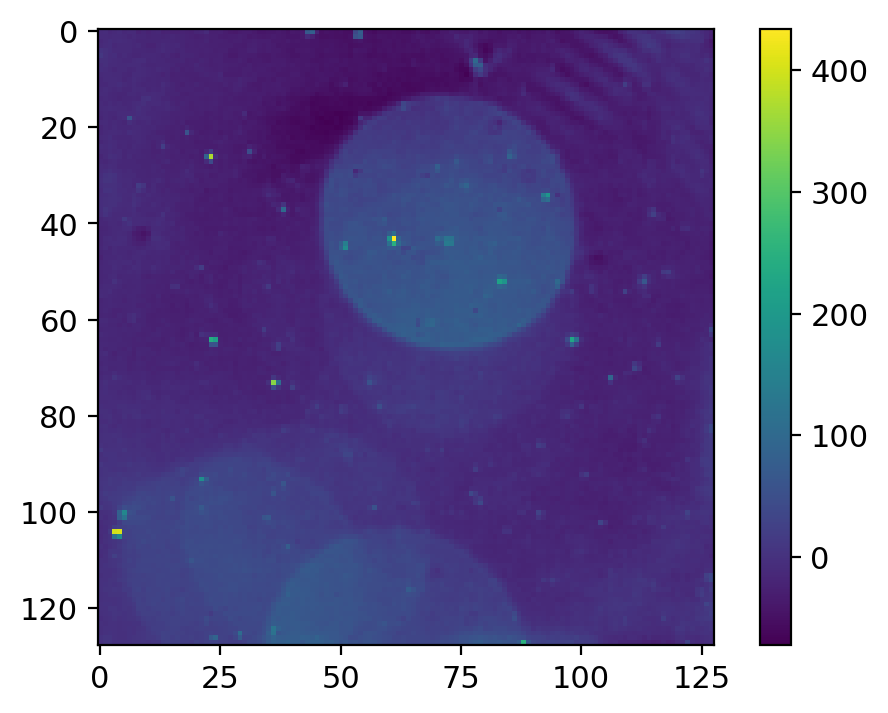

I_R  0.0
R1  2911.7261817568824
B  2911.7261817568824
residual  3.1036898552028358e-06
Y  0.0
Y  1.0553639636444178e-11
mu  3.400352535824715e-06
mu  5.100528803737072e-06


In [60]:
weight=np.ones_like(im2)
S=np.array(b.flatfield)
D=np.array(b.darkfield)
B = np.mean(im2, axis=(1, 2))
I_R = np.zeros(im2.shape, dtype=np.float32)
Y = np.zeros_like(im2, dtype=np.float32)
_temp = np.linalg.svd(im2.reshape((im2.shape[0], -1)), 
                    full_matrices=False)[1]
spectral_norm = _temp[0]

init_mu = b.mu_coef / spectral_norm
mu = init_mu
max_mu = init_mu * b.max_mu_coef
fit_residual = np.ones(im2.shape, dtype=np.float32) * np.inf
vals = (0, I_R, B, Y, mu, fit_residual)
k, I_R, B, Y, mu, fit_residual = vals
I_B = S[newax, ...] * B[:, newax, newax] + D[newax, ...]
print("I_B ",I_B.mean())

# update I_R using approximated l0 norm
I_R = I_R + (im2 - I_B - I_R + (1 / mu) * Y) 
print("I_R ",I_R.mean())
plt.imshow(I_R[0])
plt.colorbar()
plt.show()
I_R = _shrinkage(I_R, weight / ( mu))
print("I_R ",I_R.mean())
R1 = im2 - I_R
print("R1 ",R1.mean())
# A1_coeff = mean(R1)-mean(A_offset);
B = np.mean(R1, axis=(1, 2)) - np.mean(D)
print("B ",B.mean())
# A1_coeff(A1_coeff<0) = 0;
B = np.maximum(B, 0)
# Z1 = D - A1_hat - E1_hat;
fit_residual = im2 - I_B - I_R
print("residual ",fit_residual.mean())
# Y1 = Y1 + mu*Z1;
print("Y ",Y.mean())
Y = Y + mu * fit_residual
print("Y ",Y.mean())
print("mu ",mu)
mu = np.minimum(mu * b.rho, max_mu)
print("mu ",mu)

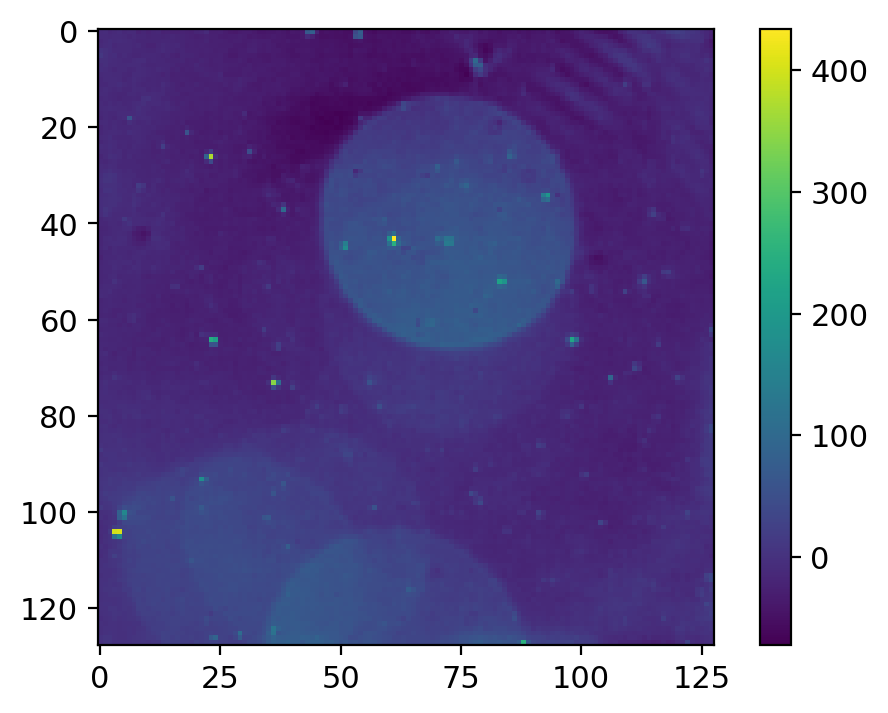

In [56]:
plt.imshow(fit_residual[0])
plt.colorbar()
plt.show()

In [ ]:
I_R  0.0
R  2911.7261817568824
B  2911.7261817568824
residual  3.103689854279412e-06
Y  0
Y  1.0553639694755e-11
mu  3.400352535824713e-06
mu  5.1005288037370695e-06

In [42]:
B = jnp.mean(im2, axis=(1, 2))
I_R = jnp.zeros(im2.shape, dtype=jnp.float32)
Y = jnp.zeros_like(im2, dtype=jnp.float32)
_temp = jnp.linalg.svd(im2.reshape((im2.shape[0], -1)), 
                        full_matrices=False)[1]
spectral_norm = _temp[0]

init_mu = b.mu_coef / spectral_norm
mu = init_mu
max_mu = init_mu * b.max_mu_coef
fit_residual = jnp.ones(im2.shape, dtype=jnp.float32) * jnp.inf
vals = (0, I_R, B, Y, mu, fit_residual)
vals=_step_only_baseline(b,im2,np.ones_like(im2),
                         b.flatfield,
                         b.darkfield,
                         vals,max_mu)

I_B  2911.7268
I_R  -5.4253476e-05
I_R  0.0
R1  2911.7258
B  2911.7263
residual  -5.4253476e-05
Y  0.0
Y  -4.2870407e-10
mu  3.4003544e-06
mu  5.100532e-06


In [48]:
I_R.min(),I_R.max()

(DeviceArray(0., dtype=float32), DeviceArray(0., dtype=float32))

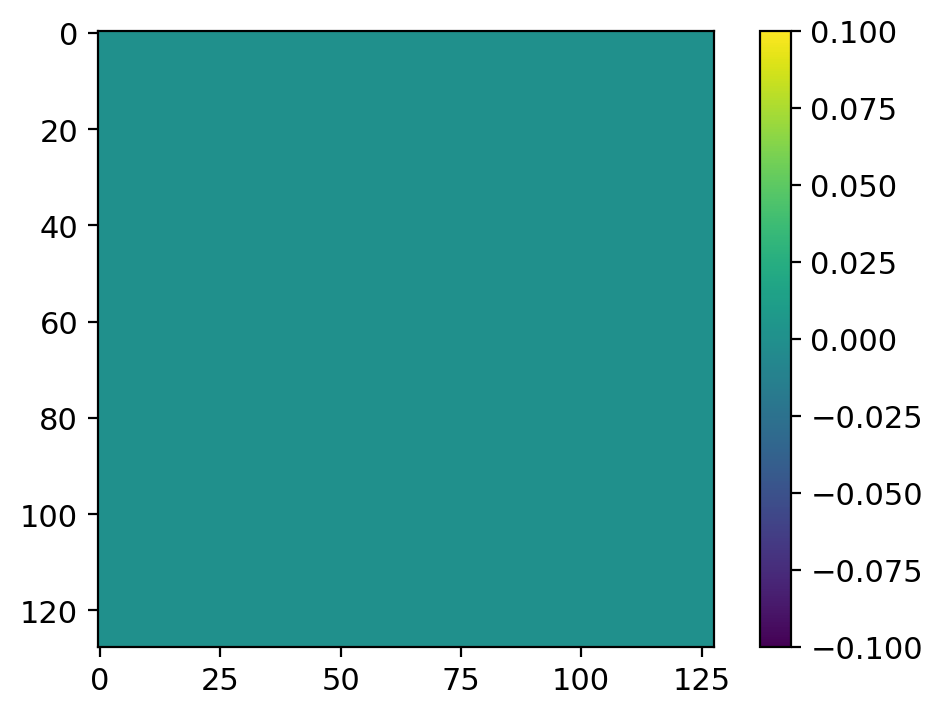

In [ ]:
I_B  2911.7261786531917
I_R  3.103689854279412e-06
I_R  0.0
R  2911.7261817568824
B  2911.7261817568824
residual  3.103689854279412e-06
Y  0
Y  1.0553639694755e-11
mu  3.400352535824713e-06
mu  5.1005288037370695e-06

(63, 16384)
I_B  2911.7261786531917
I_R  3.103689854279412e-06


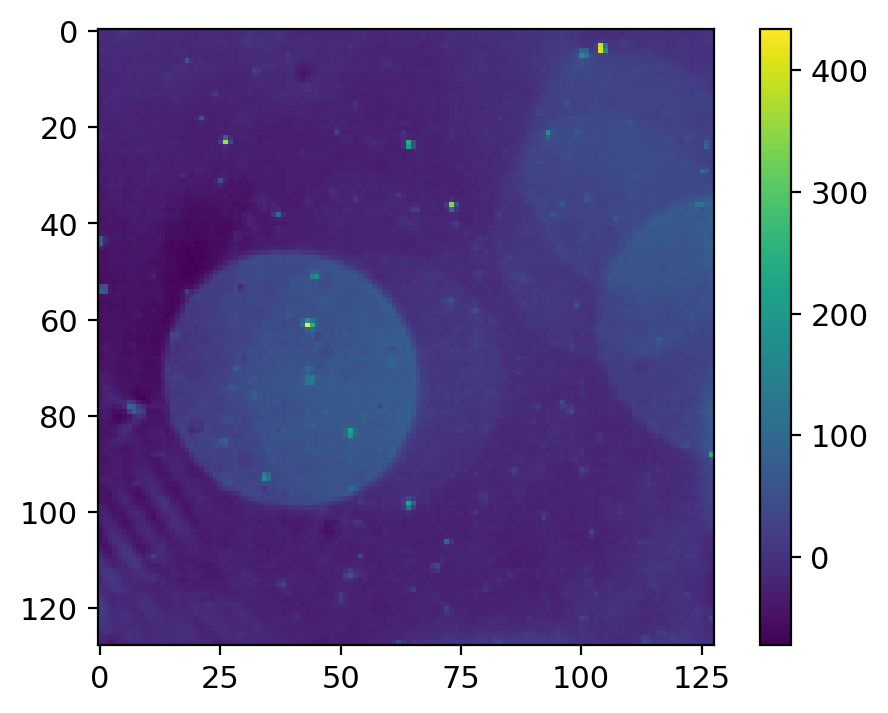

I_R  0.0
R  2911.7261817568824
B  2911.7261817568824
residual  3.103689854279412e-06
Y  0
Y  1.0553639694755e-11
mu  3.400352535824713e-06
mu  5.1005288037370695e-06

I_B  2911.7261786531917
I_R  5.172816434772018e-06


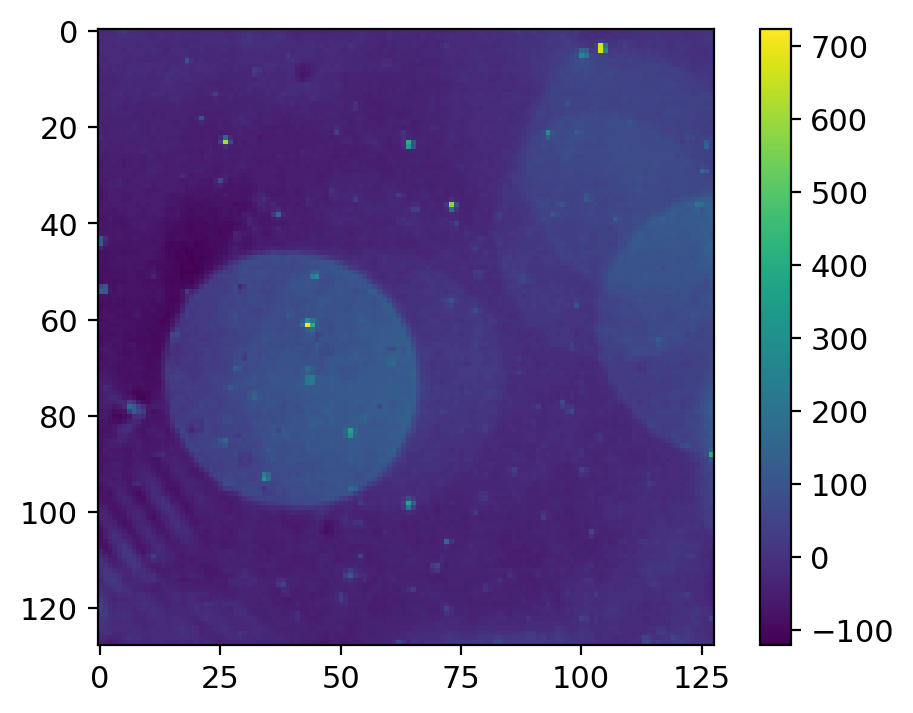

I_R  0.0
R  2911.7261817568824
B  2911.7261817568824
residual  3.103689854279412e-06
Y  1.0553639694755e-11
Y  2.6384099174549913e-11
mu  5.1005288037370695e-06
mu  7.650793205605605e-06
5.515412243903435e-10


In [57]:
def background_timelapse(
        Im,
        flatfield: np.ndarray = None,
        darkfield: np.ndarray = None,
        verbosity = True,
        ):

    """
    Computes the baseline drift for the input images and returns a numpy 1D array
    Parameters:
    ----------
    images_list : list
        A list of 2D arrays as the list of input images. The list can be provided by
        using pybasic.load_data() function.

    flatfield : numpy 2D array
        A flatfield image for input images with the same shape as them. The flatfield
        image may be calculated using pybasic.basic() function.

    darkfield : numpy 2D array, optional
        A darkfield image for input images with the same shape as them. The darkfield
        image may be calculated using the `pybasic.basic()` function.

    verbosity : Boolean
        If True the reweighting iteration number is printed (default is True).
    Returns:
    --------
        A 1d numpy array containing baseline drift for each input image. The length of
        the array equals the length of the list of input images.

    """

    nrows = ncols = Im.shape[-2]

    # Reszing
    # cv2.INTER_LINEAR is not exactly the same method as 'bilinear' in MATLAB

    Im = Im.reshape([-1, nrows * nrows], order = 'F')
    print(Im.shape)

    _weights = np.ones(Im.shape,dtype=np.float32)
    eplson = 0.1
    tol = 1e-6
    for reweighting_iter in range(1,2):
        S = np.reshape(flatfield, (1,-1), order='F')
        D = np.reshape(darkfield, (1,-1), order='F')
        B = np.mean(Im, 1).reshape([-1,1])

        # main iteration loop starts:
        # The first element of the second array of np.linalg.svd
        _temp = np.linalg.svd(Im, full_matrices=False)[1]
        norm_two = _temp[0]

        mu = 12.5/norm_two # this one can be tuned
        mu_bar = mu * 1e7
        rho = 1.5 # this one can be tuned
        d_norm = np.linalg.norm(Im, ord = 'fro')
        ent1 = 1
        _iter = 0
        converged = False;
        Is_B = np.zeros(Im.shape,dtype=np.float32)
        I_R = np.zeros(Im.shape,dtype=np.float32)
        Y = 0

        while not converged:
            _iter = _iter + 1;
            I_B = S * B + D
            print("I_B ",I_B.mean())

            # update E1 using l0 norm
            I_R = I_R + np.divide((Im - I_B - I_R + (1/mu)*Y), ent1)
            print("I_R ",I_R.mean())
            plt.imshow(np.reshape(I_R[0],(128,128)))
            plt.colorbar()
            plt.show()
            I_R = np.maximum(I_R - _weights/(ent1*mu), 0) +\
                     np.minimum(I_R + _weights/(ent1*mu), 0)
            print("I_R ",I_R.mean())
            # update A1_coeff, A2_coeff and A_offset
            #if coeff_flag

            R = Im - I_R
            print("R ",R.mean())
            B = np.mean(R,1).reshape(-1,1) - np.mean(D,1)
            B[B<0] = 0
            print("B ",B.mean())
            residual = Im - I_B - I_R
            print("residual ",residual.mean())

            print("Y ",Y.mean() if np.any(Y!=0) else 0)
            Y = Y + mu*residual
            print("Y ",Y.mean())

            print("mu ",mu.mean())
            mu = min(mu*rho, mu_bar)
            print("mu ",mu.mean())

            # stop Criterion
            stopCriterion = np.linalg.norm(residual, ord = 'fro') / d_norm
            # print(stopCriterion, tol)
            if stopCriterion < tol:
                converged = True
            # if total_svd % 10 == 0:
            #     print('stop')
            if _iter > 1:
                break
            print("")

        # updating weight
        # XE_norm = E1_hat / np.mean(A1_hat)
        mean_vec = np.mean(I_B, axis=1)
        I_R = np.transpose(np.tile(mean_vec, (nrows * nrows, 1))) / (I_R + 1e-6)
        _weights = 1./(np.abs(I_R)+eplson)
        print(np.mean(_weights))

        _weights = np.divide( np.multiply(_weights, _weights.shape[0] * _weights.shape[1]), np.sum(_weights))

    return np.squeeze(B)

baseline_orig=background_timelapse(np.array(im2),
                     np.array(b.flatfield),
                     np.array(b.darkfield))

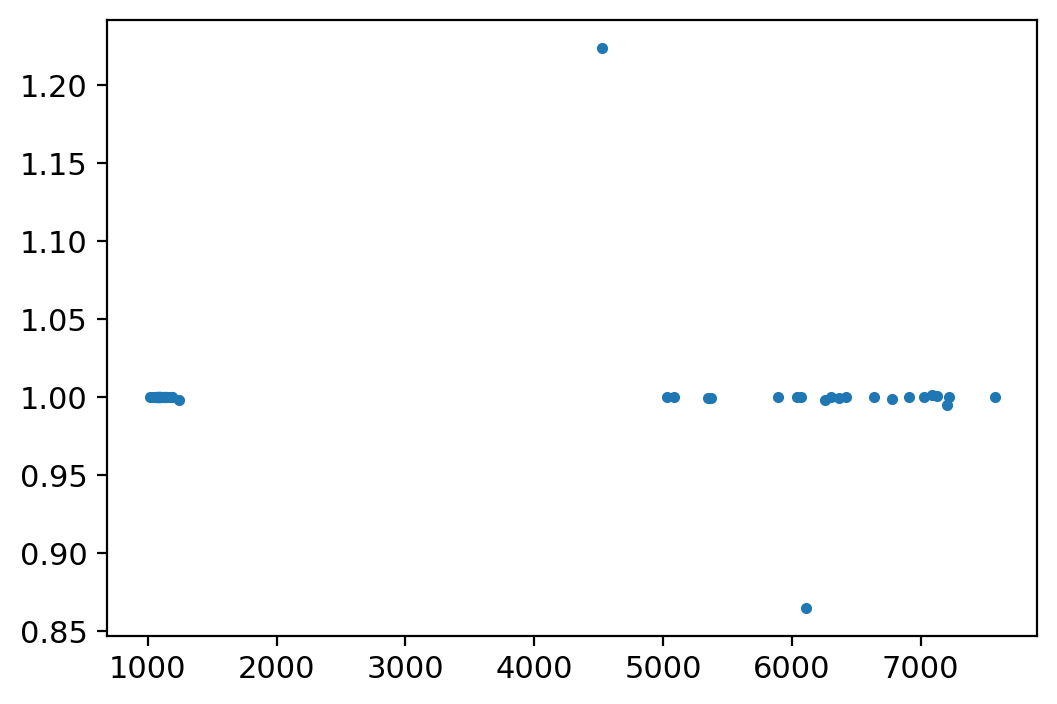

In [38]:
plt.plot(b.baseline,baseline_orig/b.baseline,".")

# Exporting data for test

In [51]:
from basicpy import BaSiC
from itertools import product
import os
import logging
logging.getLogger("basicpy").setLevel(level=logging.WARNING)

os.makedirs("../tests/data/fit", exist_ok=True)

for k,im in images.items():
    for fitting_mode, get_darkfield, sort_intensity in \
        product(["ladmap","approximate"],[True,False],[True,False]):
        b = BaSiC(fitting_mode=fitting_mode, 
#                  lambda_flatfield_coef=1.0 / 400 * 0.5 if fitting_mode=="approximate" else 0.1,
#                  lambda_darkfield_coef=0.2 if fitting_mode=="approximate" else 0.2,
                  get_darkfield=get_darkfield, 
                  sort_intensity=sort_intensity)
        b.fit(im)
        plt.figure(figsize=(15,5))
        plt.subplot(131)
        plt.imshow(b.flatfield)
        plt.colorbar()
        plt.subplot(132)
        plt.imshow(b.darkfield)
        plt.colorbar()
        plt.subplot(133)
        plt.plot(b.baseline)
        boolstr = lambda x:"with" if x else "without"
        k2=f"{k}_{fitting_mode}_{boolstr(get_darkfield)}-darkfield_{boolstr(sort_intensity)}-sort"
        plt.title(k2)
        plt.savefig(f"../tests/data/fit/plots/{k2}.png")
        plt.show()
        np.savez_compressed(f"../tests/data/fit/{k2}.npz",
            image_name=k,
            flatfield=b.flatfield,
            darkfield=b.darkfield,
            baseline=b.baseline,
            params=b.dict()
        )

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x141268550> (for post_execute):


KeyboardInterrupt: 

(147, 128, 128) uint16


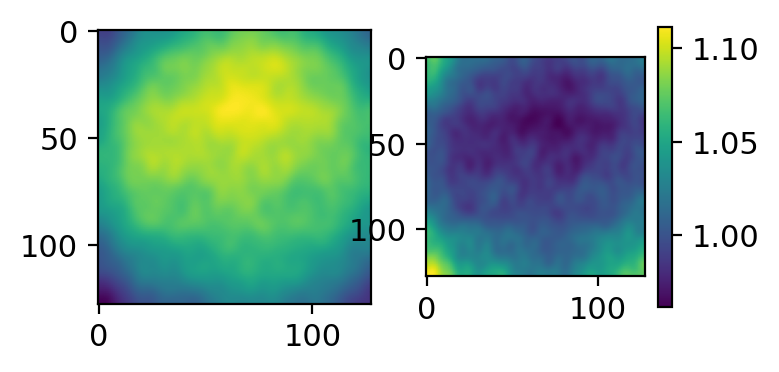

(100, 128, 171) uint8


ValueError: operands could not be broadcast together with shapes (128,128) (128,171) 

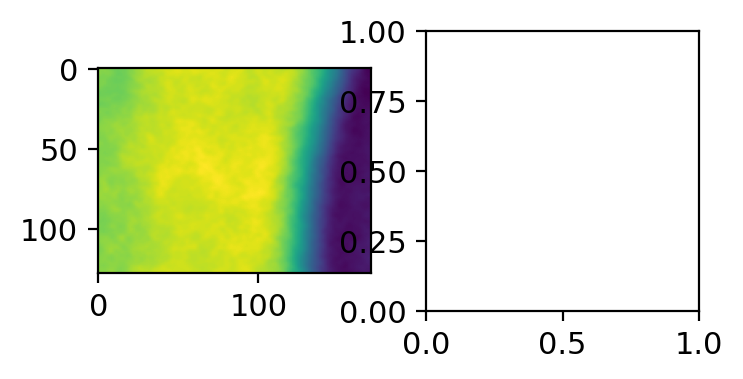